In this HW, you will make a image search engine using CLIP embeddings over validation set of Tiny-Imagenet.

You job is to create a search a search Engine which can accept both a text input and an image input (the user can give either one as querry). You will use the pretrained CLIP model (you can load it from huggingface or their repo) to compute embeddings of the querry and then use it fetch the most similar images to that query from the Tiny-Image Net Validation set.

Cmmpute and show zero-shot accuracy of CLIP on the validation set of Tiny-Imagenet. You can have a look [here](https://openai.com/index/clip/) to see how you can do zero shot classification with CLIP

Finally, use 5 random images from the web and 5 queries (write them yourself) and show the 5 most similar images from the dataset for each of them.

In [1]:
from IPython.display import clear_output
%pip install tinyimagenet
clear_output()

In [2]:
from tinyimagenet import TinyImageNet
import matplotlib.pyplot as plt

import torch
import torchvision
import numpy as np
from PIL import Image
from transformers import CLIPProcessor, CLIPModel
from tqdm import tqdm

100%|██████████| 248100043/248100043 [00:42<00:00, 5883084.99it/s]


Extracting tinyimagenet/tiny-imagenet-200.zip to tinyimagenet


TinyImageNet, split val, has  10000 samples.
Showing info of 5 samples...
Sample of class   0, image 0, words ['goldfish', ' Carassius auratus']


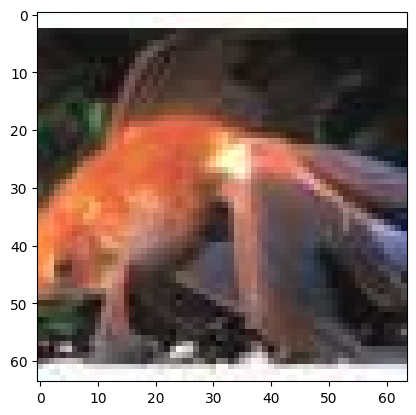

Sample of class  40, image 2000, words ['walking stick', ' walkingstick', ' stick insect']


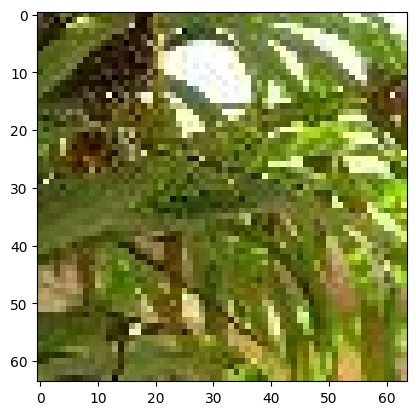

Sample of class  80, image 4000, words ['bucket', ' pail']


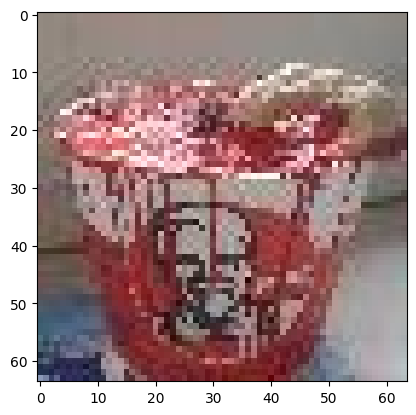

Sample of class 120, image 6000, words ['miniskirt', ' mini']


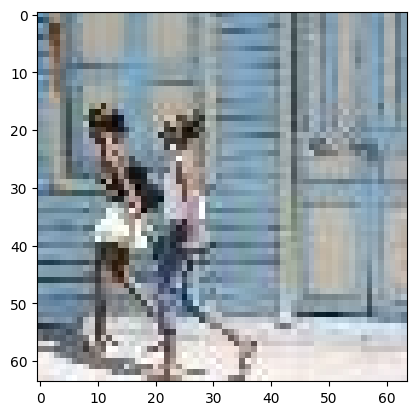

Sample of class 160, image 8000, words ['teapot']


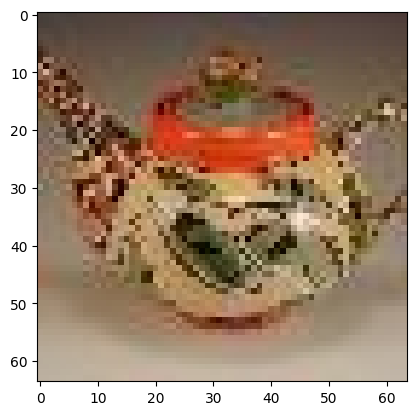

In [3]:
split ="val" # choose from "train", "val", "test"
dataset = TinyImageNet("tinyimagenet/", split=split)
n = len(dataset)
print(f"TinyImageNet, split {split}, has  {n} samples.")
n_samples = 5
print(f"Showing info of {n_samples} samples...")
for i in range(0,n,n//n_samples):
    image,klass = dataset[i]
    print(f"Sample of class {klass:3d}, image {i}, words {dataset.idx_to_words[klass]}")
    plt.imshow(image.permute(1,2,0).numpy())
    plt.show()

In [4]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, data, transformations=None):
        self.data = data
        self.transforms = transformations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image, image_class = self.data[idx]
        if self.transforms:
            image = self.transforms(image)
        return image, image_class

In [5]:
from torchvision import transforms

transformations = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073],
    #                      std=[0.26862954, 0.26130258, 0.27577711])
])

In [6]:
val_dataset = TinyImageNet("tinyimagenet/", split='val')

In [7]:
val_set = MyDataset(val_dataset, transformations)

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

def compute_image_embeddings(dataset, model, device):
    image_embeddings = []
    labels = []
    for img, label in tqdm(dataset):
        labels.append(label)
        img = img.unsqueeze(0).to(device)
        with torch.no_grad():
            img_features = model.get_image_features(img)
            img_features = img_features / img_features.norm(p=2, dim=-1, keepdim=True)
        image_embeddings.append(img_features.cpu().numpy())

    return np.concatenate(image_embeddings, axis=0), labels

image_embeddings, labels = compute_image_embeddings(val_set, model, device)

100%|██████████| 10000/10000 [02:07<00:00, 78.64it/s]


In [26]:
def get_query_embedding(query, model, processor, device):
    if isinstance(query, str):
        inputs = processor(text=query, return_tensors="pt", padding=True).to(device)
        with torch.no_grad():
            text_features = model.get_text_features(**inputs)
            text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)
        return text_features.cpu().numpy()
    elif isinstance(query, Image.Image):
        inputs = processor(images=query, return_tensors="pt").to(device)
        with torch.no_grad():
            image_features = model.get_image_features(**inputs)
            image_features = image_features / image_features.norm(p=2, dim=-1, keepdim=True)
        return image_features.cpu().numpy()

In [27]:
def search(query, image_embeddings, model, processor, dataset, device, top_k=5):
    query_embedding = get_query_embedding(query, model, processor, device)
    similarities = np.dot(image_embeddings, query_embedding.T).squeeze()
    best_indices = np.argsort(similarities)[-top_k:][::-1]
    results = [dataset.imgs[i][0] for i in best_indices]
    return results

## Results

Top results for text query: ['tinyimagenet/tiny-imagenet-200/val/n02099712/images/val_7122.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02106662/images/val_9708.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02113799/images/val_2422.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02395406/images/val_3002.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02415577/images/val_8993.JPEG']


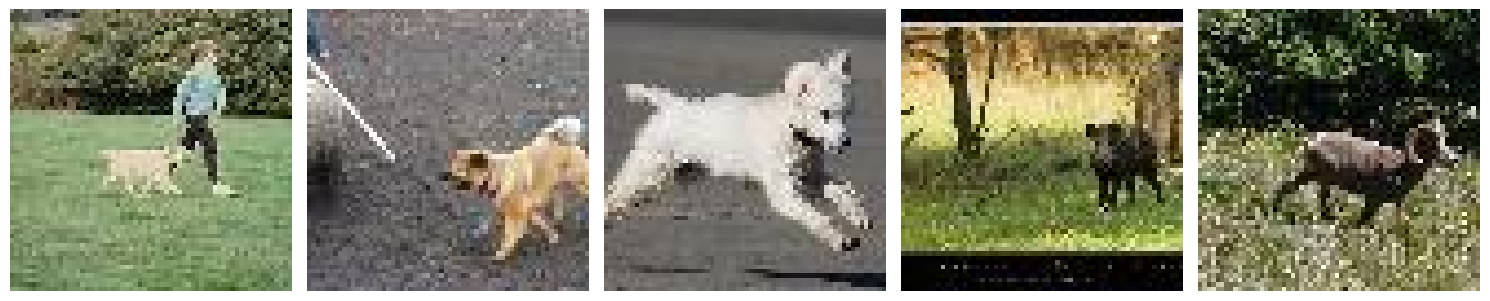

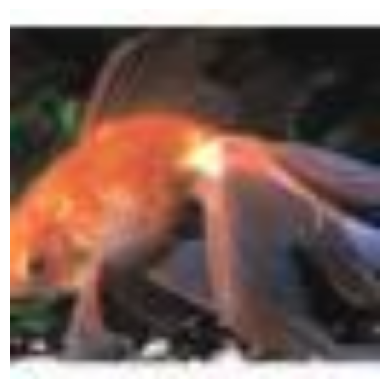


Top results for image query: ['tinyimagenet/tiny-imagenet-200/val/n01443537/images/val_1230.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02106662/images/val_4262.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n01882714/images/val_1483.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02074367/images/val_6104.JPEG', 'tinyimagenet/tiny-imagenet-200/val/n02099601/images/val_5053.JPEG']


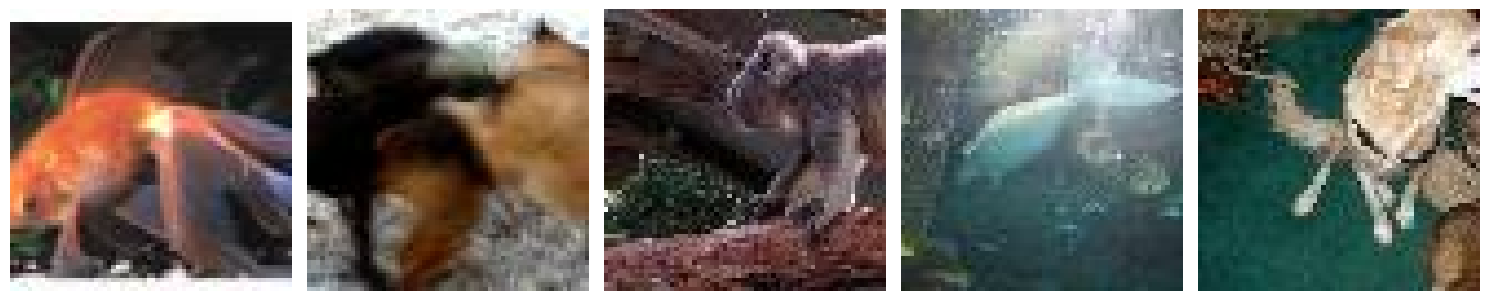

In [28]:
query_text = "a dog running"
query_image = val_set[0][0]

results = search(query_text, image_embeddings, model, processor, dataset, device)
print("Top results for text query:", results)
num_images = len(results)

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, result in enumerate(results):
    image = torchvision.io.read_image(result)
    image_np = image.permute(1, 2, 0).numpy()

    axes[i].imshow(image_np)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

plt.imshow(query_image.permute(1, 2, 0).numpy())
plt.axis('off')
plt.show()

query_image = torchvision.transforms.functional.to_pil_image(query_image)

results = search(query_image, image_embeddings, model, processor, dataset, device)
print()
print("Top results for image query:", results)

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for i, result in enumerate(results):
    image = torchvision.io.read_image(result)
    image_np = image.permute(1, 2, 0).numpy()

    axes[i].imshow(image_np)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [44]:
def compute_efficient_zero_shot_accuracy(image_embeddings, labels, dataset, top_k=1):
    total_images = len(dataset)
    correct = 0

    labels = np.array(labels)

    image_embeddings = image_embeddings / np.linalg.norm(image_embeddings, axis=1, keepdims=True)

    for idx in tqdm(range(total_images), desc="Computing accuracy"):
        query_embedding = image_embeddings[idx]
        true_label = labels[idx]

        similarities = np.dot(image_embeddings, query_embedding)
        top_indices = np.argsort(similarities)[::-1][1:top_k+1]

        predicted_labels = labels[top_indices]
        if true_label in predicted_labels:
            correct += 1

    accuracy = correct / total_images
    print(f"\nZero-shot accuracy (top-{top_k}): {accuracy:.4f}\n")

    return accuracy

accuracy = compute_efficient_zero_shot_accuracy(image_embeddings, labels, dataset, top_k=1)
accuracy = compute_efficient_zero_shot_accuracy(image_embeddings, labels, dataset, top_k=5)
accuracy = compute_efficient_zero_shot_accuracy(image_embeddings, labels, dataset, top_k=10)
accuracy = compute_efficient_zero_shot_accuracy(image_embeddings, labels, dataset, top_k=20)

Computing accuracy: 100%|██████████| 10000/10000 [00:15<00:00, 632.33it/s]



Zero-shot accuracy (top-1): 0.3599



Computing accuracy: 100%|██████████| 10000/10000 [00:15<00:00, 629.40it/s]



Zero-shot accuracy (top-5): 0.5962



Computing accuracy: 100%|██████████| 10000/10000 [00:16<00:00, 622.39it/s]



Zero-shot accuracy (top-10): 0.6875



Computing accuracy: 100%|██████████| 10000/10000 [00:22<00:00, 440.36it/s]


Zero-shot accuracy (top-20): 0.7699

